The underlying dataset contains MRI images of 260 cases in dicom format with 15-18 slices for each case and a xlsx containing patient information pertaining to the images.
This notebook aims to build a CNN which is able to classify the images into 'has demency' or 'has no demency'.


In [1]:
import pydicom
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#read in xlsx data
df = pd.read_excel(r'C:\Users\dontknowVP\Desktop\denis_patrick_clowns\IBMB_Dataset_true_false.xlsx', index_col=0)

In [2]:
# Set Seed value for reproducable results
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)


In [3]:
#settings
layer=10 #use layer 11, as layer 11 contains the highest amount of white matters if demency 

### data preperation
read in dicom data

sort the mri image layers 

drop images with 15 layers, as there are only 6 patients with 15 layers

shuffle data

reshape data

divide into train and test images and labels

apply ImageDataGenerator

In [4]:
#read in data
#set patient data
#set global data (all patient)
#data[0] contains patient0 all images
#data[0][0] contains patient 0 image 0


data=[]

global_path=r'C:\Users\dontknowVP\Desktop\denis_patrick_clowns\IBMB Dataset'
for dirname in os.listdir(global_path):
    if dirname.endswith("") : 
        path=global_path+'\\' + dirname
        
        dirname=os.listdir(path)[0]
        path=path+'\\' + dirname
        dirname=os.listdir(path)[0]
        path=path+'\\' + dirname
        patient_data=[]
        for filename in os.listdir(path):
            file_dirname=path+'\\'+filename
            patient_data.append(pydicom.read_file(file_dirname))
        data.append(patient_data)
        
        


In [5]:
def show_image(image):

    plt.title('Sample: %d  Label: %d' % (2, 1))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
   

In [6]:
# sort MRI image layers
# add demency level

for i in range(len(data)):
    for x in range(len(data[i])):
        data[i].sort(key=lambda y: y.InstanceNumber, reverse=False)
        data[i][x].pvwm=df['PVWM'][int(str(data[i][x].PatientName))]
        data[i][x].age=df["Patient's Age"][int(str(data[i][x].PatientName))]

    
#drop images with 15 layers
data.pop(18)  
data.pop(123)
data.pop(156) 
data.pop(183)
data.pop(227) 
data.pop(239)  


counter_15=0
counter_16=0
counter_17=0
counter_18=0
print('length of data:',len(data))
#check images for number of layers

for i in range(len(data)):
    if(len(data[i])==15):
        counter_15=counter_15+1
        print(i)
    if(len(data[i])==16):
        counter_16=counter_16+1
    if(len(data[i])==17):
        counter_17=counter_17+1
    if(len(data[i])==18):
        counter_18=counter_18+1    

print(counter_15,counter_16,counter_17,counter_18)    


len_data= len(data)

length of data: 254
0 0 0 253


In [7]:
print(len(data))

254


In [8]:
  
#shuffle data
print(data[0][7].PatientName)
import random
random.seed(64)
from random import shuffle 
shuffle(data)
print(data[0][7].PatientName)

#max columns: 224

980500221101
980503341101


In [9]:
#playground cell


In [10]:
#reshape and split into training/test data
#M1 only
M1_images=[]

for i in range(len(data)):
    M1_images.append(data[i][layer]) 
    

all_images=np.array([])
all_images2=np.array([])
all_images3=np.array([])
all_images4=np.array([])
all_classes=np.array([])
classes_array=[]
images_array=[]
new_pixel_array=np.array([])
counter=0
for i in M1_images:
    diff=224-i.pixel_array.shape[1]      #add pixels of value 0 --> all iamges shape (256,224)
    z = np.zeros((256,diff))      
    add_to_array_array=np.append(i.pixel_array, z, axis=1).reshape(1,256,224)    
    add_to_array_array[0][0][0]=i.age
    if counter==0:
        all_images=add_to_array_array
    else:
        all_images=np.append(all_images, add_to_array_array, axis=0)
    classes_array.append(i.pvwm)
    counter=counter+1
    

print(all_images[0].shape)    
all_classes=np.array(classes_array)



train_images = all_images[:173]
test_images = all_images[173:]
train_classes = all_classes[:173]
test_classes = all_classes[173:]

#256,224 reshape
train_images = train_images.reshape(train_images.shape[0], 256, 224,1)
test_images = test_images.reshape(test_images.shape[0], 256, 224,1)
train_classes = tf.keras.utils.to_categorical(train_classes, 2)
test_classes = tf.keras.utils.to_categorical(test_classes, 2)










train_images=train_images.astype('float32')
train_images/=255
test_images=test_images.astype('float32')
test_images/=255

# fits the model on batches with real-time data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=5,
    #brightness_range=(0.95, 1),
    shear_range=0.1, #0.
    width_shift_range=0.3,
    height_shift_range=0.05,
    vertical_flip=True)

datagen.fit(train_images)

(256, 224)


### modelling
build CNN

apply CNN on training data

In [11]:
#CNN
input_shape=(256, 224,1)
model = Sequential()
model.add(Conv2D(16, (3, 3),activation=('relu'),input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3),activation=('relu'))) 
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(16, (3, 3),activation=('relu')))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1000,activation=('relu')))
model.add(Dropout(0.2))
model.add(Dense(1000,activation=('relu')))
model.add(Dropout(0.2))
model.add(Dense(2,activation=('softmax')))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])



In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 222, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 109, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 54, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 52, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 26, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 26, 16)        0

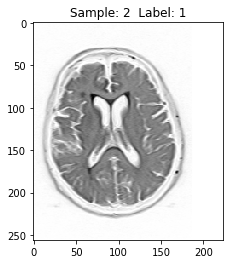

  ...
    to  
  ['...']
Train for 18 steps, validate on 81 samples
Epoch 1/500
18/18 - 3s - loss: 0.7131 - accuracy: 0.4971 - val_loss: 0.6911 - val_accuracy: 0.4568
Epoch 2/500
18/18 - 2s - loss: 0.6927 - accuracy: 0.4509 - val_loss: 0.6895 - val_accuracy: 0.4568
Epoch 3/500
18/18 - 2s - loss: 0.6881 - accuracy: 0.5318 - val_loss: 0.6752 - val_accuracy: 0.6790
Epoch 4/500
18/18 - 2s - loss: 0.6811 - accuracy: 0.6185 - val_loss: 0.6965 - val_accuracy: 0.4568
Epoch 5/500
18/18 - 2s - loss: 0.6752 - accuracy: 0.5838 - val_loss: 0.6493 - val_accuracy: 0.6914
Epoch 6/500
18/18 - 2s - loss: 0.6781 - accuracy: 0.5549 - val_loss: 0.6626 - val_accuracy: 0.5802
Epoch 7/500
18/18 - 2s - loss: 0.6828 - accuracy: 0.5838 - val_loss: 0.6608 - val_accuracy: 0.6296
Epoch 8/500
18/18 - 2s - loss: 0.6929 - accuracy: 0.5723 - val_loss: 0.6496 - val_accuracy: 0.5926
Epoch 9/500
18/18 - 2s - loss: 0.6940 - accuracy: 0.5087 - val_loss: 0.6597 - val_accuracy: 0.5926
Epoch 10/500
18/18 - 2s - loss: 0.6863 - 

In [ ]:
show_image(all_images[0])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history = model.fit(datagen.flow(train_images, train_classes,
                    batch_size=10) ,#50
                    epochs=500,
                    verbose=2,
                    validation_data=(test_images, test_classes))
print('MRI LAYER: ', layer+1)

score = model.evaluate(test_images, test_classes, verbose=0)
print("Test loss: ", score[0])
print("Test acc: ", score[1])

### Evaluation

In [ ]:
score = model.evaluate(test_images, test_classes, verbose=0)
print("Test loss: ", score[0])
print("Test acc: ", score[1])

In [ ]:

for patient_number in range(190,240):
    reshaped_img=all_images_concat[patient_number].reshape(1,256,224,1)
    

    show_image(all_images_concat[patient_number])
    print('observation:',all_classes[patient_number])
    print('prediction',model.predict(reshaped_img))